In [679]:
# !pip install ucimlrepo
# !pip install optuna

In [680]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

import time
from sklearn.neural_network import MLPClassifier
from tensorflow import keras

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [681]:
RANDOM_SEED = 0

In [682]:
def get_data(name):
    from ucimlrepo import fetch_ucirepo

    features, targets = np.array([]), np.array([])

    # fetch dataset
    if name == "yeast":
        dataset = fetch_ucirepo(id=110)
        features = dataset.data.features.to_numpy()
        targets = dataset.data.targets.to_numpy()
        targets = targets.ravel()
    elif name == "spambase":
        dataset = fetch_ucirepo(id=94)
        features = dataset.data.features.to_numpy()
        targets = dataset.data.targets.to_numpy()
        targets = targets.ravel()
    elif name == "rice":
        dataset = fetch_ucirepo(id=545)
        features = dataset.data.features.to_numpy()
        targets = dataset.data.targets.to_numpy()
        targets = targets.ravel()
    elif name == "churn":
        dataset = fetch_ucirepo(id=563)
        features = dataset.data.features.to_numpy()
        targets = dataset.data.targets.to_numpy()
        targets = targets.ravel()
    elif name == "health_nutri":
        dataset = fetch_ucirepo(id=887)
        features = dataset.data.features.to_numpy()
        targets = dataset.data.targets.to_numpy()
        targets = targets.ravel()
    elif name == "zoo":    # Good small ds.
      dataset = fetch_ucirepo(id=111)
      features = dataset.data.features.to_numpy()
      targets = dataset.data.targets.to_numpy()
      targets = targets.ravel()
    elif name == "parkinsons":    # 197x22 Good for all. Fit for comparisons
      dataset = fetch_ucirepo(id=174)
      features = dataset.data.features.to_numpy()
      targets = dataset.data.targets.to_numpy()
      targets = targets.ravel()
    elif name == "monk":  
      dataset = fetch_ucirepo(id=70)
      features = dataset.data.features.to_numpy()
      targets = dataset.data.targets.to_numpy()
      targets = targets.ravel()
    elif name == "thyroid":  #useless
        data = pd.read_csv('ann-train.data', header=None)

        # Assuming the last column is the class label
        features = data.iloc[:, :-1]
        labels = data.iloc[:, -1]
    elif name == "marketing":   # awesome for ANN
        data = pd.read_csv('marketing_campaign.csv', sep="\t")
        # drop missing values
        data = data.dropna()

        features = data.iloc[:, :-1].to_numpy()
        targets = data.iloc[:, -1].to_numpy()
        targets = targets.ravel()

        # Encoding the education column
        from sklearn.preprocessing import OneHotEncoder
        onehotencoder = OneHotEncoder(sparse_output=False)

        encoded = onehotencoder.fit_transform(features[:,2].reshape(-1, 1))

        ft1 = np.concatenate((features[:, :2], encoded, features[:, 3:]), axis=1)
        # now we encode the marital status
        encoded = onehotencoder.fit_transform(ft1[:,7].reshape(-1, 1))
        ft2 = np.concatenate((ft1[:, :7], encoded, ft1[:, 8:]), axis=1)

        # removing the date column
        ft2 = np.concatenate((ft2[:, :18], ft2[:, 19:]), axis=1)
        features = ft2


    return features, targets

In [683]:
def encode_onehot(labels):
    onehotencoder = OneHotEncoder(sparse_output=False)
    encoded_categories = onehotencoder.fit_transform(labels.reshape(-1, 1))

    return encoded_categories
    
def encode_label(labels):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    encoded = le.fit_transform(y)
    return encoded

In [684]:
def plot_learning_curve(model, features, labels):
  features, labels = shuffle(features, labels, random_state=RANDOM_SEED)
  from sklearn.model_selection import StratifiedKFold
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

  # scale the features?
  #scaler = StandardScaler()
  #X_scaled = scaler.fit_transform(X)

  train_sizes, train_scores, test_scores = learning_curve(
    model, features, labels, cv=5, scoring='accuracy', n_jobs=-1,
    random_state=RANDOM_SEED, shuffle=True,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Varying the size of training data. also try (0.1, 1.0, 20)
  )

  # Calculate mean and standard deviation for train and test scores
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  # Plot learning curve
  plt.figure(figsize=(8, 6))
  plt.plot(train_sizes, train_mean, label='Training score', color='blue')
  plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green')
  # Plot the std deviation as a shaded region
  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.1)

  # Labeling the plot
  plt.title('Learning Curve (Accuracy vs Training size)')
  plt.xlabel('Training Set Size')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.grid()
  plt.savefig("figures/learning_curve.png")
  # Show plot
  plt.show()


In [685]:
def plot_params_knn(p_values, weight_options, results):
  plt.figure(figsize=(12, 8))

  # Create subplots for each distance metric (p=1, p=2)
  for i, p_value in enumerate(p_values):
      plt.subplot(1, 2, i + 1)
      plt.title(f'KNN with p={p_value} (Manhattan)' if p_value == 1 else f'KNN with p={p_value} (Euclidean)')

      # Plot uniform and distance-based weights
      for weights in weight_options:
          subset = results[(results[:, 1] == p_value) & (results[:, 2] == weights)]
          plt.plot(subset[:, 0], subset[:, 3], label=f'weights={weights}')

      plt.xlabel('Number of Neighbors (K)')
      plt.ylabel('Cross-Validation Accuracy')
      plt.legend()
      plt.grid(True)

  # Adjust layout and show the plot
  plt.tight_layout()
  plt.savefig("figures/knn_tune.png")
  plt.show()

In [686]:
def manually_tune_knn(X_train_scaled, ytrain):

  # Define hyperparameter values to tune
  n_neighbors_values = range(1, 31)  # Loop over neighbors from 1 to 30
  p_values = [1, 2]  # 1: Manhattan, 2: Euclidean distance
  weight_options = ['uniform', 'distance']  # Uniform or distance-based weighting

  # Empty list to store the results
  results = []

  # Loop over all combinations of hyperparameters
  for n_neighbors in n_neighbors_values:
      for p in p_values:
          for weights in weight_options:
              # Create KNN model with current hyperparameters
              knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, weights=weights)

              # Perform cross-validation (5-fold)
              cv_scores = cross_val_score(knn, X_train_scaled, ytrain, cv=3, scoring='accuracy')

              # Calculate the mean accuracy
              mean_cv_score = np.mean(cv_scores)

              # Store the result (n_neighbors, p, weights, mean_cv_score)
              results.append((n_neighbors, p, weights, mean_cv_score))

  # Convert results to a NumPy array for easier processing
  results = np.array(results, dtype=object)

  # Find the best hyperparameter combination (max accuracy)
  best_index = np.argmax(results[:, 3].astype(float))
  best_params = results[best_index]
  best_n_neighbors = best_params[0]
  best_p = best_params[1]
  best_weights = best_params[2]
  best_score = best_params[3]

  # Print the best hyperparameters and their corresponding accuracy
  print(f"Best Hyperparameters: n_neighbors={best_n_neighbors}, p={best_p}, weights={best_weights}")
  print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

  plot_params_knn(p_values, weight_options, results)

In [687]:
def compare_k_values(xtrain, ytrain, xtest, ytest, data_name):
    k_vals = [i for i in range(1,40)]
    train_accuracies = []
    test_accuracies = []
    for k in k_vals:
        #classifier = KNeighborsClassifier(n_neighbors = k, metric = 'minkowski', p = 2)
        if data_name == "marketing":
            classifier = KNeighborsClassifier(n_neighbors=k, p=2, algorithm="auto", leaf_size=10, weights="uniform")
        else:
            classifier = KNeighborsClassifier(n_neighbors=k, p=1, algorithm="auto", leaf_size=10, weights="uniform")
        classifier.fit(xtrain, ytrain)

        y_pred_test = classifier.predict(xtest)
        y_pred_train = classifier.predict(xtrain)

        train_accuracies.append(accuracy_score(ytrain, y_pred_train))
        test_accuracies.append(accuracy_score(ytest, y_pred_test))


    # now let's plot it - Accuracy vs k
    plt.figure(figsize=(10, 6))
    plt.plot(k_vals, train_accuracies, label='In-Sample Accuracy (Training Set)', marker='o', color='b')
    plt.plot(k_vals, test_accuracies, label='Out-of-Sample Accuracy (Test Set)', marker='o', color='r')
    plt.title('KNN Accuracy for Different Values of k')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.xticks(k_vals)
    plt.legend()
    plt.grid(True)
    plt.savefig("figures/differentks.png")
    plt.show()

In [688]:
# plot svm params
def plot_params_svm(gamma_values, results,degree_values):
   # ---------------------- PLOTTING RESULTS ---------------------- #
  # Separate results for plotting
  linear_results = results[results[:, 1] == 'linear']
  rbf_results = results[results[:, 1] == 'rbf']
  poly_results = results[results[:, 1] == 'poly']

  # Plot the results for linear kernel
  plt.figure(figsize=(18, 6))

  plt.subplot(1, 3, 1)
  plt.title('SVM with Linear Kernel')
  plt.plot(linear_results[:, 0], linear_results[:, 4], marker='o', label='Linear Kernel')
  plt.xscale('log')
  plt.xlabel('C (Regularization parameter)')
  plt.ylabel('Cross-Validation Accuracy')
  plt.grid(True)

  # Plot the results for RBF kernel with different gamma values
  plt.subplot(1, 3, 2)
  plt.title('SVM with RBF Kernel')
  for gamma in gamma_values:
      subset = rbf_results[rbf_results[:, 2] == gamma]
      plt.plot(subset[:, 0], subset[:, 4], marker='o', label=f'Gamma={gamma}')
  plt.xscale('log')
  plt.xlabel('C (Regularization parameter)')
  plt.ylabel('Cross-Validation Accuracy')
  plt.legend()
  plt.grid(True)

  # Plot the results for poly kernel with different degrees (p)
  plt.subplot(1, 3, 3)
  plt.title('SVM with Poly Kernel')
  for degree in degree_values:
      subset = poly_results[poly_results[:, 3] == degree]
      plt.plot(subset[:, 0], subset[:, 4], marker='o', label=f'Degree={degree}')
  plt.xscale('log')
  plt.xlabel('C (Regularization parameter)')
  plt.ylabel('Cross-Validation Accuracy')
  plt.legend()
  plt.grid(True)
  plt.savefig("figures/svm_tune")

  # Adjust layout and show the plot
  plt.tight_layout()
  plt.show()

In [689]:
def manually_tune_svm(X_train_scaled, ytrain):
    # Define hyperparameter values to tune
  C_values = np.logspace(-3, 2, 6)  # Different values of C (from 0.001 to 100)
  gamma_values = ['scale', 'auto']  # Options for gamma (scale or auto)
  kernel_options = ['linear', 'rbf', 'poly']  # We now include the poly kernel
  degree_values = range(2, 7)  # Values of degree (p) for the poly kernel (from 2 to 6)

  # Empty list to store the results
  results = []

  # Loop over all combinations of hyperparameters
  for C in C_values:
      for kernel in kernel_options:
          if kernel == 'rbf':  # Only relevant for RBF kernel
              for gamma in gamma_values:
                  # Create SVM model with RBF kernel and current hyperparameters
                  svm = SVC(C=C, kernel=kernel, gamma=gamma)

                  # Perform cross-validation (5-fold)
                  cv_scores = cross_val_score(svm, X_train_scaled, ytrain, cv=5, scoring='accuracy')
                  #print("scores: ", cv_scores)

                  # Calculate the mean accuracy
                  mean_cv_score = np.mean(cv_scores)

                  # Store the result (C, kernel, gamma, None, mean_cv_score)
                  results.append((C, kernel, gamma, None, mean_cv_score))

          elif kernel == 'poly':  # Only relevant for poly kernel
              for degree in degree_values:
                  # Create SVM model with poly kernel and current hyperparameters
                  svm = SVC(C=C, kernel=kernel, degree=degree)

                  # Perform cross-validation (5-fold)
                  cv_scores = cross_val_score(svm, X_train_scaled, ytrain, cv=5, scoring='accuracy')

                  # Calculate the mean accuracy
                  mean_cv_score = np.mean(cv_scores)

                  # Store the result (C, kernel, None, degree, mean_cv_score)
                  results.append((C, kernel, None, degree, mean_cv_score))

          else:  # Linear kernel
              # Create SVM model with linear kernel
              svm = SVC(C=C, kernel=kernel)

              # Perform cross-validation (5-fold)
              cv_scores = cross_val_score(svm, X_train_scaled, ytrain, cv=5, scoring='accuracy')

              # Calculate the mean accuracy
              mean_cv_score = np.mean(cv_scores)

              # Store the result (C, kernel, None, None, mean_cv_score)
              results.append((C, kernel, None, None, mean_cv_score))

  # Convert results to a NumPy array for easier processing
  results = np.array(results, dtype=object)

  # Find the best hyperparameter combination (max accuracy)
  best_index = np.argmax(results[:, 4].astype(float))
  best_params = results[best_index]
  best_C = best_params[0]
  best_kernel = best_params[1]
  best_gamma = best_params[2]  # Relevant for RBF kernel
  best_degree = best_params[3]  # Relevant for Poly kernel
  best_score = best_params[4]

  # Print the best hyperparameters and their corresponding accuracy
  print(f"Best Hyperparameters: C={best_C}, kernel={best_kernel}, gamma={best_gamma}, degree={best_degree}")
  print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

  plot_params_svm(gamma_values,results,degree_values)

In [690]:
def run_grid_search(xtrain, ytrain, model_type="knn"):
    from sklearn.model_selection import GridSearchCV
    from sklearn.neighbors import KNeighborsClassifier

    model = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': range(1, 31),  # Test different k values
        'weights': ['uniform', 'distance'],  # Test both uniform and distance weighting
        'p': [1, 2],  # Test Manhattan and Euclidean distance
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Test different search algorithms
        'leaf_size': [10, 20, 30, 40, 50]  # Different leaf sizes for tree-based methods
        }

    if model_type == "svm":
        model = SVC()
        param_grid = {
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'C': [0.1, 1, 10, 100],
          'gamma': ['scale', 'auto'],
          'degree': [2, 3, 4],  # Only relevant for 'poly' kernel
          'coef0': [0, 0.1, 0.5, 1]  # Relevant for 'poly' and 'sigmoid' kernels
       }
    elif model_type == "ann":
        model = MultilayerPerceptron()


    # Set up the grid search with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, shuffle=True)

    # Fit the model
    grid_search.fit(xtrain, ytrain)

    return grid_search.best_params_, grid_search.best_score_

In [691]:
# Tuning with Optuna

def run_optuna_ann(xtrain, ytrain, xtest, ytest):
    import optuna
    from tensorflow import keras
    from tensorflow.keras import layers
    from sklearn.preprocessing import StandardScaler

    def create_model(trial):
        model = keras.Sequential()
        model.add(layers.Dense(trial.suggest_int('units', 4, 32), activation='relu', input_shape=(xtrain.shape[1],)))
        if ytrain.ndim == 1:
            model.add(layers.Dense(1, activation='sigmoid'))
        else:
            model.add(layers.Dense(ytrain.shape[1], activation='softmax'))

        optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy' if ytrain.ndim ==1 else 'categorical_crossentropy', metrics=['accuracy'])
        return model

    def objective(trial):
        model = create_model(trial)
        model.fit(xtrain, ytrain, epochs=trial.suggest_int('epochs', 10, 50), batch_size=trial.suggest_int('batch_size', 16, 64), verbose=0)
        score = model.evaluate(xtest, ytest, verbose=0)
        return score[1]

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))
    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

In [692]:
def plot_fit_and_predict_times(X, y, models=None):
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the dataset (important for SVM and ANN)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the models to benchmark
    # if models is None:
    #   models = {
    #       'KNN': KNeighborsClassifier(n_neighbors=5),
    #       'SVM': SVC(kernel='rbf', C=1, gamma='scale'),
    #       'ANN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
    #   }

    # Empty dictionaries to store timing results
    fit_times = {}
    predict_times = {}

    # Loop over models to measure fit and predict times
    for model_name, model in models.items():
        # Measure the time taken to fit the model
        start_fit = time.time()
        model.fit(X_train_scaled, y_train)
        end_fit = time.time()

        # Measure the time taken to predict using the model
        start_predict = time.time()
        model.predict(X_test_scaled)
        end_predict = time.time()

        # Calculate and store the elapsed times
        fit_times[model_name] = end_fit - start_fit
        predict_times[model_name] = end_predict - start_predict

    # Print out the results
    print("Fit Times (in seconds):", fit_times)
    print("Predict Times (in seconds):", predict_times)

    # ---------------------- PLOTTING RESULTS ---------------------- #
    # Set up the plot
    model_names = list(models.keys())
    fit_values = list(fit_times.values())
    predict_values = list(predict_times.values())

    bar_width = 0.35  # Width of the bars
    index = np.arange(len(model_names))  # X locations for the models

    plt.figure(figsize=(10, 6))

    # Bar chart for fit times
    plt.bar(index, fit_values, bar_width, label='Fit Time')

    # Bar chart for predict times (stacked beside fit times)
    plt.bar(index + bar_width, predict_values, bar_width, label='Predict Time')

    # Add labels and title
    plt.xlabel('Models')
    plt.ylabel('Time (seconds)')
    plt.title('Fit and Predict Times for KNN, SVM, and ANN')
    plt.xticks(index + bar_width / 2, model_names)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.savefig("figures/train_test_times.png")
    plt.show()


In [693]:
def run_ann_validation_plot(xtrain, ytrain, xtest, ytest):

    def create_model(num_hidden_layers, units_per_layer):
        model = keras.Sequential()
        model.add(layers.Dense(units_per_layer, activation='relu', input_shape=(xtrain.shape[1],)))
        for _ in range(num_hidden_layers - 1):
            model.add(layers.Dense(units_per_layer, activation='relu'))

        if ytrain.ndim == 1:
            model.add(layers.Dense(1, activation='sigmoid'))
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        else:
            model.add(layers.Dense(ytrain.shape[1], activation='softmax'))
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    num_hidden_layers_list = [1, 2, 3]
    epochs_list = [10, 30, 50, 70, 90, 110, 150]
    results = {}

    for num_hidden_layers in num_hidden_layers_list:
        for epochs in epochs_list:
            model = create_model(num_hidden_layers, 32)  # 32 or 128?
            history = model.fit(xtrain, ytrain, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)
            train_acc = history.history['accuracy'][-1]
            test_loss, test_acc = model.evaluate(xtest, ytest, verbose=0)
            #results[(num_hidden_layers, epochs)] = test_acc
            results[(num_hidden_layers, epochs)] = (train_acc, test_acc)

    # # Plot the results
    # fig, ax = plt.subplots()
    # for num_hidden_layers in num_hidden_layers_list:
    #     accuracies = [results[(num_hidden_layers, epochs)] for epochs in epochs_list]
    #     ax.plot(epochs_list, accuracies, label=f'{num_hidden_layers} hidden layers')

    # ax.set_xlabel('Epochs')
    # ax.set_ylabel('Accuracy')
    # ax.set_title('Effect of Number of Hidden Layers and Epochs on Model Performance')
    # ax.legend()
    # plt.show()

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    for num_hidden_layers in num_hidden_layers_list:
        train_accuracies = [results[(num_hidden_layers, epochs)][0] for epochs in epochs_list]
        test_accuracies = [results[(num_hidden_layers, epochs)][1] for epochs in epochs_list]
        ax[0].plot(epochs_list, train_accuracies, label=f'{num_hidden_layers} hidden layers')
        ax[1].plot(epochs_list, test_accuracies, label=f'{num_hidden_layers} hidden layers')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training Accuracy')
    ax[0].set_title('Training Accuracy vs. Epochs')
    ax[0].legend()

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Test Accuracy')
    ax[1].set_title('Test Accuracy vs. Epochs')
    ax[1].legend()
    plt.savefig("figures/ann_tune.png")

    plt.tight_layout()
    plt.show()

# RUN ALL
- get dataset 1
- get dataset 2
- run gridsearch or manual tune for ds1
- plot validation plots (hyperparameters tuning) ds1
- learning curve KNN, SVM, ANN1, ANN2 for ds1

- Repeat for ds2
- do decision tree and implement boosting for ds1

In [694]:
def run_knn(data_name, encode_type=None):
    X, y = get_data(data_name)
    test_size = 0.20

    if encode_type == "onehot":
        y = encode_onehot(y)
    elif encode_type == "label":
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y = le.fit_transform(y)

    # splitting into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    # feature scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # run grid_search for hyperparameter tuning.
    # print("Running grid search")
    # best_params, best_scores = run_grid_search(X_train, y_train)
    # print(f"Grid search done. Best params: {best_params} \nBest score: {best_scores}")


    classifier = KNeighborsClassifier(n_neighbors=8, metric='minkowski', p=2)
    #classifier = KNeighborsClassifier(n_neighbors=5, weights="distance")
    # classifier = KNeighborsClassifier(n_neighbors=30, p=2, algorithm="auto", leaf_size=10, weights="distance") #{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
    classifier.fit(X_train, y_train)

    # predicting on training and test sets
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)

    print("pridiction done.")
    # cm_train = confusion_matrix(y_train, y_pred_train)
    print(f"Insample prediction for {data_name}= {accuracy_score(y_train, y_pred_train)}")
    print(f"Out-sample prediction for {data_name}= {accuracy_score(y_test, y_pred_test)}")

In [695]:
def run_ann(data_name, encode_type=None):
    import random
    seed_value = 0
    # 1. Set seed for Python's random module
    random.seed(seed_value)
    # 2. Set seed for NumPy
    np.random.seed(seed_value)

    # 3. Set seed for TensorFlow
    tf.random.set_seed(seed_value)


    X, y = get_data(data_name)
    test_size = 0.30

    if encode_type == "onehot":
        y = encode_onehot(y)
    elif encode_type == "label":
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y = le.fit_transform(y)

    # splitting into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    # feature scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)



    # run grid_search for hyperparameter tuning.

    # create the ANN model
    # initialize the ann
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(units=X.shape[1], activation='relu')) # input and first hidden layer
    ann.add(tf.keras.layers.Dense(units=64, activation='relu'))  # 2nd hidden layer
    ann.add(tf.keras.layers.Dense(units=64, activation='relu'))  # 3rd hidden layer

    if y.ndim == 1:
        ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
        ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    else:
        ann.add(tf.keras.layers.Dense(units=y.shape[1], activation='softmax'))
        ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    ann.fit(X_train, y_train, batch_size=32, epochs=100, shuffle=False)

    # Predictions
    y_pred_train = ann.predict(X_train)

    # Evaluate the model
    loss_train, accuracy_train = ann.evaluate(X_train, y_train)
    loss_test, accuracy_test = ann.evaluate(X_test, y_test)
    print(f"Train Accuracy: {accuracy_train:.2f}")
    print(f"Test Accuracy: {accuracy_test:.2f}")

In [696]:
def run_svm(data_name, encode_type=None):
    X, y = get_data(data_name)
    test_size = 0.20

    if encode_type == "onehot":
        y = encode_onehot(y)
    elif encode_type == "label":
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y = le.fit_transform(y)

    # splitting into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    # feature scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # run grid_search for hyperparameter tuning.
    # print("Running grid search")
    # best_params, best_scores = run_grid_search(X_train, y_train)
    # print(f"Grid search done. Best params: {best_params} \nBest score: {best_scores}")

    print("p3")
    # training on train set
    classifier = SVC(kernel="rbf", degree=2, random_state=0)
    #classifier = SVC(kernel="poly", degree=4, random_state=0)
    #classifier = SVC(kernel="rbf", degree=3, random_state=0)
    print("p1")
    classifier.fit(X_train, y_train)
    print("p2")
    # predicting on training and test sets
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)


    print("pridiction done.")
    #cm_train = confusion_matrix(y_train, y_pred_train)
    print(f"Insample prediction for {data_name}= {accuracy_score(y_train, y_pred_train)}")
    print(f"Out-sample prediction for {data_name}= {accuracy_score(y_test, y_pred_test)}")

In [697]:
def plot_performance_vs_iterations_ann(data_name, xtrain, ytrain):
    import matplotlib.pyplot as plt
    from keras.models import Sequential
    from keras.layers import Dense
    
    # Define the model
    model = Sequential()
    if data_name == "marketing":
        model.add(Dense(9, input_dim=xtrain.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    elif data_name == "monk":
            model.add(Dense(32, input_dim=xtrain.shape[1], activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_size = 0.8
    X_train_part, X_temp, y_train_part, y_temp = train_test_split(xtrain, ytrain, train_size=train_size, random_state=RANDOM_SEED)
    #X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, xx_test, y_val, yy_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=RANDOM_SEED)
    # Train the model and record history
    history = model.fit(X_train_part, y_train_part, validation_data=(X_val, y_val), epochs=100, batch_size=10, verbose=0)
    
    # Plot learning curves
    plt.figure()
    plt.title("Learning Curve (Performance vs. Iterations) for the Marketing Dataset")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    
    plt.legend(loc="best")
    plt.savefig("figures/ann_perf_vs_iter.png")
    plt.show()

def plot_performance_vs_train_size(data_name, xtrain, ytrain):
    import numpy as np
    import matplotlib.pyplot as plt
    from keras.models import Sequential
    from keras.layers import Dense
    from sklearn.model_selection import train_test_split
    
    # Define the model
    def create_model():
        model = Sequential()
        if data_name == "marketing":
            model.add(Dense(9, input_dim=xtrain.shape[1], activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        elif data_name == "monk":
            model.add(Dense(32, input_dim=xtrain.shape[1], activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    # Initialize variables
    train_sizes = np.linspace(0.1, 0.9, 9)
    train_scores = []
    test_scores = []
    
    # Loop over different training sizes
    for train_size in train_sizes:
        X_train_part, X_temp, y_train_part, y_temp = train_test_split(xtrain, ytrain, train_size=train_size, random_state=RANDOM_SEED)
        #X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, xx_test, y_val, yy_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=RANDOM_SEED)
        model = create_model()
        history = model.fit(X_train_part, y_train_part, validation_data=(X_val, y_val), epochs=38, batch_size=33, verbose=0)
        train_scores.append(history.history['accuracy'][-1])
        test_scores.append(history.history['val_accuracy'][-1])
    
    # Plot learning curves
    plt.figure()
    plt.title("Learning Curves (Performance vs. Training Size) for the Marketing Dataset")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.grid()
    
    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training accuracy")
    plt.plot(train_sizes, test_scores, 'o-', color="g", label="Validation accuracy")
    
    plt.legend(loc="best")
    plt.savefig("figures/ann_perf_vs_train_size.png")
    plt.show()

def plot_learning_curves_ann(data_name, xtrain, ytrain):
    plot_performance_vs_iterations_ann(data_name, xtrain, ytrain)
    plot_performance_vs_train_size(data_name, xtrain, ytrain)

In [698]:
# RUN THIS CELL FOR THE MARKETING DATASET

def run_marketing_ds():
    X, y = get_data("marketing")
    sc = StandardScaler()
    X = sc.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # now scale the features.
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Run KNN manual parameter tuning
    #manually_tune_knn(X, y)   # this should return the best model based on the tuning
    # best params: k=15, p=2, weights = distance. Accuracy = 0.8718
    #compare_k_values(X_train, y_train, X_test, y_test, "marketing")
    knn = KNeighborsClassifier(n_neighbors=15, metric='minkowski', p=2)  # replace with the optimized params
    # plot_learning_curve(knn, X, y)
    
    # Run svm tuning and learning curve
    # manually_tune_svm(X, y)
    svm = SVC(kernel="linear", C=10, random_state=0)
    # plot_learning_curve(svm, X, y)
    
    # Run Gridsearch (Optuna)  for ANN and plot LC
    #y_encoded = encode_onehot(y)  # oneHot encode zoo since it's multicalss
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    #run_optuna_ann(X_train, y_train, X_test, y_test)
    # run_ann_validation_plot(X_train, y_train, X_test, y_test)
    # plot_learning_curves_ann("marketing", X_train, y_train)

    # Let's plot the train and predict times
    ann = Sequential()
    ann.add(Dense(9, input_dim=X_train.shape[1], activation='relu'))
    ann.add(Dense(1, activation='sigmoid'))
    ann.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        
    models = {
          'KNN': knn,
          'SVM': svm,
          'ANN': ann
      }
    plot_fit_and_predict_times(X, y, models=models)
    
    print("done")


In [699]:
# RUN THIS CELL FOR THE MONK DATASET
def run_monk_ds():
    print("---------Running the Monk dataset --------")
    X, y = get_data("monk")
    sc = StandardScaler()
    X = sc.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

    # now scale the features.
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    #Run KNN manual parameter tuning
    # manually_tune_knn(X, y)   # this should return the best model based on the tuning
    # # best params: k=5, p=1. Accuracy (95, 83)
    # compare_k_values(X_train, y_train, X_test, y_test, "monk")
    knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1)  # replace with the optimized params
    plot_learning_curve(knn, X, y)
    
    # Run svm tuning and learning curve
    # manually_tune_svm(X, y)
    svm = SVC(kernel="rbf", random_state=0)
    # plot_learning_curve(svm, X, y)
    
    # # Run Gridsearch (Optuna)  for ANN and plot LC
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # run_optuna_ann(X_train, y_train, X_test, y_test)
    # run_ann_validation_plot(X_train, y_train, X_test, y_test)
    # plot_learning_curves_ann("monk", X_train, y_train)

    # Let's plot the train and predict times
    ann = Sequential()
    ann.add(Dense(14, input_dim=X_train.shape[1], activation='relu'))
    ann.add(Dense(1, activation='sigmoid'))
    ann.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        
    models = {
          'KNN': knn,
          'SVM': svm,
          'ANN': ann
      }
    plot_fit_and_predict_times(X, y, models=models)
    
    print("done")


---------Running the Monk dataset --------


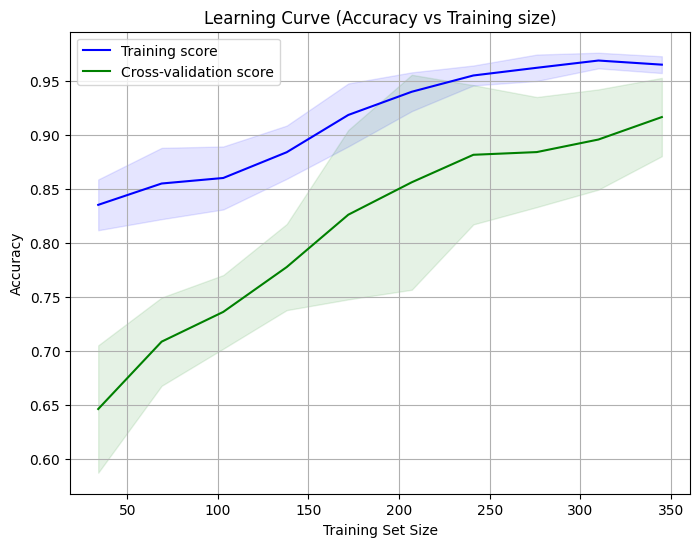

C:\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5718 - loss: 0.7136  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Fit Times (in seconds): {'KNN': 0.0, 'SVM': 0.005963325500488281, 'ANN': 0.8459718227386475}
Predict Times (in seconds): {'KNN': 0.0060579776763916016, 'SVM': 0.0029959678649902344, 'ANN': 0.14522886276245117}


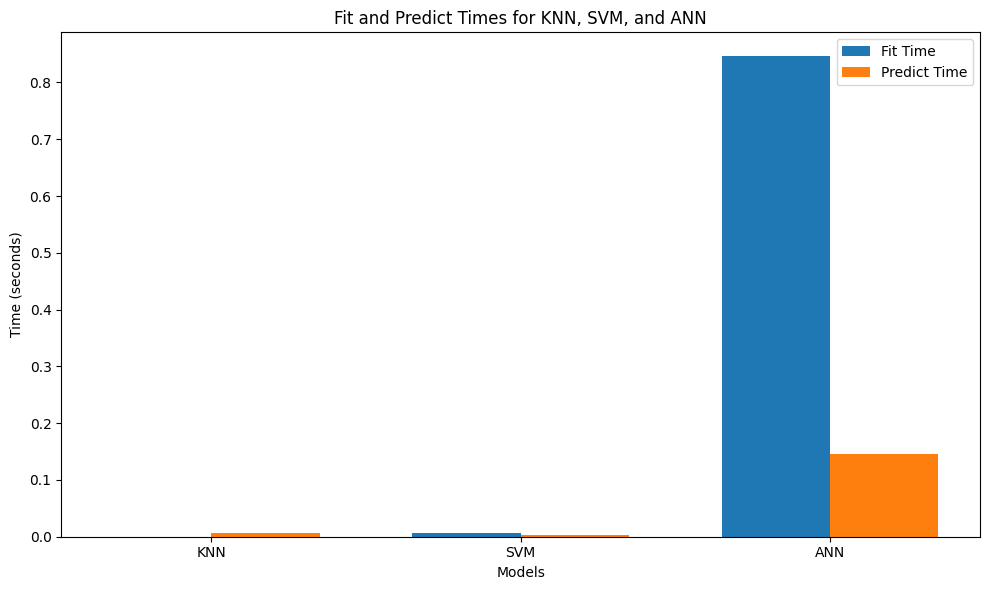

done


In [700]:
import os
if not os.path.exists("figures"):
    os.makedirs("figures")
run_monk_ds()
#run_marketing_ds()